<a href="https://colab.research.google.com/github/tvkk1999/ML_Prac/blob/main/2_End_to_End_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The main steps in an end-to-end ML:
1. Figure out the problem statement
2. Gather the data
3. Explratory data analysis and visualization
4. Data preparation
5. Model selection and training
6. Fine-tuning the model
7. Solution presenation
8. Launch, monitor, and maintain your system.


# 1. The problem statement
- Your Task is to build a

###Notes
- A sequence of data processing components is called a data *_pipeline_*.
- The components in the data pipeline typically run asynchronously.
- Proper monitoring is needed to aviod unnoticed component failures.

## Loading the dataset

In [123]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def laod_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = laod_housing_data()

In [124]:
housing.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
housing.info()

In [ ]:
housing['ocean_proximity'].value_counts()

In [ ]:
housing.describe()

In [ ]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  print(shuffled_indices)
  test_set_size = int(len(data) * test_ratio)
  print(test_set_size)
  test_indices = shuffled_indices[:test_set_size]
  print(test_indices)
  train_indices = shuffled_indices[test_set_size:]
  print(train_indices)
  return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [ ]:
len(train_set), len(test_set)

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the `shuffle_and_split_data()` function we defined earlier.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
train_set, test_set

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [106]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
splitter

StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None)

In [107]:
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])
  # print(train_index, test_index)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
strat_splits[:1]

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.title("California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population")
plt.show()

### Look for Correlations

In [ ]:
corr_matrix = housing.select_dtypes(include=['number']).corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
# scatter matrix - which plots every numerical attribute against every other numerical attribute.
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

So far we have seen:
- Few data quirks that should be cleaned.
- Found interesting correlations between attributes, in particular with the target attribute.
- Some attributes have a skewed-right distribution, which should be transformed.

### Experiment with Attribute Combinations

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household.

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [108]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
corr_matrix = housing.select_dtypes(include=["number"]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

## Prepare the data for ML algos

In [ ]:
# revert to a clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the data

Three options to fix missing values:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median, etc.). This is called *_imputation_*.

In [ ]:
housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1

housing.drop("total_bedrooms", axis=1) # option 2

median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)

You decide to go for option 3 since it is the least destructive, but instead of the preceding code, you will use a handy Scikit-Learn class: `SimpleImputer`.

The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
# median can only be computed on numerical attributes, so invlude only numerical values

housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

In [ ]:
print(imputer.statistics_)
print(housing_num.median().values)

In [ ]:
X = imputer.transform(housing_num)

Missing values can also be replaced with the mean value (`strategy="mean"`), or with the most frequent value (`strategy="most_frequent"`), or with a constant value (`strategy="constant", fill_value=…`​). The last two strategies support non-numerical data.

There are also more powerful imputers available in the `sklearn.impute` package (both for numerical features only):

`KNNImputer` replaces each missing value with the mean of the k-nearest neighbors’ values for that feature. The distance is based on all the available features.

`IterativeImputer` trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices) even when they are fed Pandas DataFrames as input.⁠

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [ ]:
housing_tr.head()

## Handling text and Categorical Attributes

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

In [109]:
# ocean_proximity is a categorical attribute
# most ML algos prefer to work with numbers
# so convert these categories from text to numbers

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [110]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [111]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it is obviously not the case for the `ocean_proximity` column.

 To fix this issue, a common solution is to create one binary attribute per category.

 This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

 The new attributes are sometimes called dummy attributes.

In [112]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [113]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16344 stored elements and shape (16344, 5)>

In [114]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [115]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  # now a dense array

In [116]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [117]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling and Transformation

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

#### Min-max scaling (*normalization*)
- Simplest
- For each attibute, the values are rescaled so that they end up ranging from 0 to 1.
- scaled_x = (x - min)/(max - min)
- Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if, for some reason, you don’t want 0–1 (e.g., neural networks work best with zero-mean inputs, so a range of –1 to 1 is preferable).

In [118]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [119]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

#### Standardization
- First it subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standardized values have a standard deviation equal to 1).
- Scikit-Learn provides a transformer called `StandardScaler` for standardization

In [120]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [121]:
housing_num_std_scaled

array([[-1.42263435,  1.01312356,  1.86068722, ...,  0.13757239,
         1.395732  , -0.93755681],
       [ 0.5966805 , -0.70227426,  0.90752642, ..., -0.69327638,
        -0.3735368 ,  1.1713802 ],
       [-1.20270897,  1.2755888 ,  0.35151595, ..., -0.78823052,
        -0.77599971, -0.76081193],
       ...,
       [ 1.25645664, -1.42874055, -1.23708538, ...,  1.26789191,
         0.67966161,  0.10023117],
       [ 0.58668389, -0.73976929,  0.66923622, ...,  0.27361246,
         0.88350647,  0.14458922],
       [-1.41763605,  0.94750725,  1.22524669, ..., -0.67866805,
        -0.75247915, -0.31125713]])

If you want to scale a sparse matrix without converting it to a dense matrix first, you can use a `StandardScaler` with its `with_mean` hyperparameter set to False: it will only divide the data by the standard deviation, without subtracting the mean (as this would break sparsity).

- When a feature's distribution has a *heavy tail* (i.e., when values far from the mean are not exponentially rare), both min-max scalling and standardization will squash most values into a small range.
- ML models generally don't like this at all.
- So before you scale the feature:
  - Should first transform it to shrink the heavy tail
  - and if possible to make the distribution roughly symmetrical.
- A common way for positive features is by replacing the feature with it's square root or raising the feature values to a power between 0 and 1.
- If the feature has a really long and heavy tail (like a *power law distribution*), then replace the feature with its logarithm may help.


Another approach ro handle heavy-tailed features is *Bucketization*.
- chopping its distribution into roughly equal-sized buckets, and
- replacing each feature value with the index of the bucket it belongs to

Bucketizing with equal-sized buckets results in a feature with an almost uniform distribution, so there’s no need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.

When a feature has a *multimodal distribution* (i.e., with two or more clear peaks, called modes), it can also be helpful to bucketize it.
In such cases weher we have to treat the bucket_ids as categories, rather than numerical values, we have to encode them, like using `OneHotEncoder`. So usually don't want to use too many buckets.

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode.

The similarity measure is typically computed using a *radial basis function* (RBF).
- Any function that depends only on the distance between the input value and a fixed point.
- The most commonly used RBF is the **Gaussian RBF**, whose output value decays exponentially as the input value moves away from the fixed point.
- E.g. exp(–γ(x – 35)²), the hyperparameter γ (gamma) determines how quickly the similarity measure decays as x moves away from 35.


In [122]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
age_simil_35

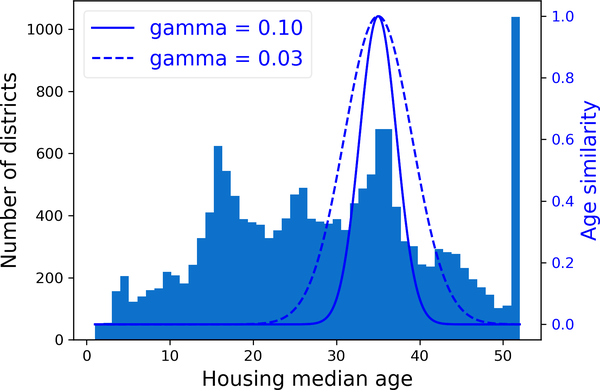

As the chart shows, the new age similarity feature peaks at 35, right around the spike in the housing median age distribution: if this particular age group is well correlated with lower prices, there’s a good chance that this new feature will help.

The target values may also need to be transformed. For example, if the target distribution has a heavy tail, you may choose to replace the target with its logarithm.

Then the pridicted values will also be the log of the values. You need to compute the exponential of the model's prediction.

Luckily, most of Scikit-Learn’s transformers have an `inverse_transform()` method

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)